# Counterfactuals in SIR epidemic (Ebola)

In [1]:
import sys
if '../../' not in sys.path:
    sys.path.append('../../')
import copy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns
import plotutils
from graph_generation import make_ebola_network
from dynamics import SimulationSIR, sample_seeds
from tqdm import tqdm
from multiprocessing import cpu_count, Pool
plt.style.use(['science','no-latex'])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

## Predefined Network settings

In [2]:
# n_nodes = 8000  # Desired number of nodes (we only keep the giant component, so actual number of nodes may be smaller)
# p_in = 0.01  # Intra-district edge probability
# p_out = {  # Inter-district edge probability
#            'Guinea': 0.00215,
#           'Liberia': 0.00300, 
#      'Sierra Leone': 0.00315, 
#     'inter-country': 0.0019
# }

# # Generate scaled graph with settings
# G = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=None)

Run simulation on graph with predefined settings

In [3]:
# Sample seeds from the dataset (random set from infections seen before the given date, taking into account possible random recovery)
# init_event_list = sample_seeds(graph=G, delta=1.0 / 11.4, method='data', max_date='2014-01-01')

In [4]:
# alls = []
# for _ in range(100):
#     init_event_list = sample_seeds(graph=G, delta=1.0 / 11.4, method='data', max_date='2014-01-01', verbose=False)
#     distric = {}
#     for i in range(0, len(init_event_list), 2):
#         j =init_event_list[i] 
#         if G.nodes(data = True)[j[0][0]]['district'].title() not in distric.keys():
#             distric[G.nodes(data = True)[j[0][0]]['district'].title()] = 1
#         else:
#             distric[G.nodes(data = True)[j[0][0]]['district'].title()] += 1
#     alls.append(distric)
#     alls.append('\n')

# import json
# with open('seeds.json', 'w') as fout:
#     json.dump(alls, fout)
#     print(sir_obj.G.nodes(data = True)[j[0][0]]['district'].title(), end = ', ')

In [5]:
# with open('seeds.txt', 'w+') as file:
#     for dct in alls:
#         file.write(str(dct))

In [6]:
import pickle
# with open('Data/seed3', 'wb') as fp:
#     pickle.dump(init_event_list, fp)
# later to load
with open ('Data/seed1', 'rb') as fp:
    init_event_list = pickle.load(fp)

In [7]:
# # Initialize object
# sir_obj = SimulationSIR(G, # Graph of individuals
#                         beta=1.0 / 15.3,  # Infection rate (advised by literature)
#                         delta=1.0 / 11.4,  # Recovery rate (advised by literature)
#                         gamma=0.0, rho=0.0,  # Treatement values, should remain zero
#                         verbose=False)

# # Run the sumulation
# sir_obj.launch_epidemic(init_event_list=init_event_list, max_time=120)

In [8]:
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)  
# save_object(sir_obj, 'Data/sir_obj3')

with open ('Data/sir_obj1', 'rb') as fp:
    sir_obj = pickle.load(fp)

In [9]:
for i in range(0, len(init_event_list), 2):
    j =init_event_list[i]
    print(sir_obj.G.nodes(data = True)[j[0][0]]['district'].title(), end = ', ')

Western, Pujehun, Tonkolili, Western, Gueckedou, Gueckedou, 

In [10]:
# creates a map between districts and blocks. (Will be needed in isolation and anslysis)
blocks = []
districts = []
block_to_district = {}
district_to_block ={}
for k, v in enumerate(sir_obj.G.nodes(data=True)):
    if v[1]['block'] not in blocks:
        blocks.append(v[1]['block'])
    if v[1]['district'] not in districts:
        districts.append(v[1]['district'])
    block_to_district[v[1]['block']] = v[1]['district']
    district_to_block[v[1]['district']] = v[1]['block']
print('number of different blocks (districts) is: {}'.format(len(blocks)))

number of different blocks (districts) is: 55


## Utility functions

In [11]:
# Returns whether nodes are infected at some time or not.
def nodes_at_time(time, type, sir_obj):
    if type == 'ori':
        return sir_obj.nodes_at_time('I', time)
    elif type == 'cf':
        return (sir_obj.cf_rec > time) * (sir_obj.cf_inf < time)
    else:
        print('Invalid type.')

## Intervention 1: Isolation

In [12]:
import random

def isolate_district(district_name, G):
    # Cuts all edges between the district and the rest of the graph.
    block = district_to_block[district_name]
    for node in np.array(G.nodes()):
        if G.nodes()[node]['block'] == block:
            for neighbor in list(G.neighbors(node)):
                if G.nodes()[neighbor]['block'] != block:
                    G.remove_edge(node, neighbor)
                    
def isolate_interior(district_name, G):
    # within one distric, cuts edges with 50% probability
    block = district_to_block[district_name]
    edges = copy.deepcopy(G.edges)
    for edge in edges:
        if G.nodes()[edge[0]]['block'] == block and G.nodes()[edge[1]]['block'] == block:
            if random.random() < 0.5:
                G.remove_edge(edge[0], edge[1])                   

<BarContainer object of 120 artists>

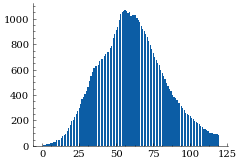

In [13]:
ori_number_of_cases = [np.count_nonzero(nodes_at_time(i, 'ori', sir_obj)) for i in range(sir_obj.max_time)]
plt.bar(range(sir_obj.max_time), ori_number_of_cases)

In [ ]:
sir_obj.calculate_counterfactual(sir_obj.beta, sir_obj.G)
maximum_days = sir_obj.max_time + 20

In [15]:
# find the days that the number of total cases exceeded some threshold
number_of_cases = [np.count_nonzero(nodes_at_time(i,'ori', sir_obj)) for i in range(maximum_days)]
cases_thresholds = [300, 600, 900]
cut_thresholds = []
for t in cases_thresholds:
    for day, nc in enumerate(number_of_cases):
        if nc >= t:
            cut_thresholds.append(day)
            break
print(cut_thresholds)

[26, 35, 50]


In [16]:
# find the cities in which had the max #cases/population untill that time threshold.
population = np.zeros(55)
for k, v in enumerate(sir_obj.G.nodes(data=True)):
    population[v[1]['block']] += 1
cut_districts = []
for day in cut_thresholds:
    cases = np.zeros(55)
    for k, v in enumerate(sir_obj.G.nodes(data=True)):
        if sir_obj.inf_occured_at[sir_obj.node_to_idx[v[0]]] <= day:
            cases[v[1]['block']] += 1
    max_district = block_to_district[np.argmax(cases/population)]
    cut_districts.append(max_district)
print(cut_districts)

['WESTERN', 'WESTERN', 'WESTERN']


In [17]:
def counterfactual(_):
    sir_obj.calculate_counterfactual(sir_obj.beta, G_prime, intervention_time = _)
    res = np.array([np.count_nonzero(nodes_at_time(i, 'cf', sir_obj)) for i in range(maximum_days)])
    return res

In [18]:
number_of_counterfactuals = 20
target_dfs = []
for i, day in enumerate(cut_thresholds):
    G_prime = copy.deepcopy(sir_obj.G)
    isolate_district(cut_districts[i], G_prime)
    isolate_interior(cut_districts[i], G_prime)
    with Pool(48) as pool:
        resultt = list(tqdm(pool.imap(counterfactual, [day for i in range(number_of_counterfactuals)]), total = number_of_counterfactuals))
    d = []
    for i in range(maximum_days):
        for j in range(len(resultt)):
            d.append([i + 1, resultt[j][i]])

    df = pd.DataFrame(d, columns=['days', 'Number of cases'])
    target_dfs.append(df)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


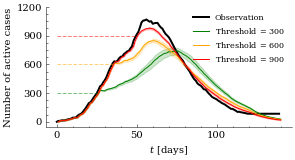

In [19]:
number_of_cases = [np.count_nonzero(nodes_at_time(i,'ori', sir_obj)) for i in range(maximum_days)]
width_pt = 397
fig_height, fig_aspect = plotutils.get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_height * 2, fig_height))
ax.plot(range(maximum_days), number_of_cases, label = 'Observation', linewidth=2.0, color = 'k')
sns.lineplot(data=target_dfs[0], x="days", y="Number of cases", label = r'Threshold $= {}$'.format(cases_thresholds[0]), color ='green').set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=target_dfs[1], x="days", y="Number of cases", label = r'Threshold $= {}$'.format(cases_thresholds[1]), color ='orange').set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=target_dfs[2], x="days", y="Number of cases", label = r'Threshold $= {}$'.format(cases_thresholds[2]), color ='red').set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
# sns.lineplot(data=target_dfs[3], x="days", y="Number of cases", label = r'Active cases $> {}$'.format(cases_thresholds[3]), color ='red').set(xlabel= "t [days]", ylabel= "Number of Active cases")
plt.plot([0, cut_thresholds[0]],[cases_thresholds[0], cases_thresholds[0]],'--', color ='green', alpha = 0.5)
plt.plot([0, cut_thresholds[1]],[cases_thresholds[1], cases_thresholds[1]],'--', color ='orange', alpha = 0.5)
plt.plot([0, cut_thresholds[2]],[cases_thresholds[2], cases_thresholds[2]],'--', color ='red', alpha = 0.5)
# plt.plot([0, cut_thresholds[3]],[cases_thresholds[3], cases_thresholds[3]],'--', color ='red', alpha = 0.5)
ax.set_yticks(range(0,1500,300))
ax.set_xticks(range(0,150,50))
ax.legend(loc = 'upper right', fontsize=8)
# ax.legend(loc = 'upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('FIG/sir_isolation.pdf', bbox_inches = 'tight')

Here, we wish to sparcify the network with some percentage and compare different percentages : 5%, 10%, 15%, 20%, 25%

In [19]:
def sparcify(percentage, G):
    edges = copy.deepcopy(G.edges)
    for edge in edges:
        if random.random() < percentage:
            G.remove_edge(edge[0], edge[1])              

In [ ]:
dfss = []
percentages = [0.05, 0.1, 0.15, 0.2, 0.25]
maximum_days = sir_obj.max_time + 20
sir_obj.calculate_counterfactual(sir_obj.beta, sir_obj.G)

In [33]:
def counterfactual2(_):
    sir_obj.calculate_counterfactual(sir_obj.beta, G_prime, intervention_time = cut_thresholds[2])
    res = np.array([np.count_nonzero(nodes_at_time(i, 'cf', sir_obj)) for i in range(maximum_days)])
    return res

In [34]:
number_of_counterfactuals = 20
for per in percentages:
    d = []
    for k in range(5):
        G_prime = copy.deepcopy(sir_obj.G)
        sparcify(per, G_prime)
        with Pool(48) as pool:
            resultt = list(tqdm(pool.imap(counterfactual2, list(range(number_of_counterfactuals))), total = number_of_counterfactuals))
        for i in range(maximum_days):
            for j in range(len(resultt)):
                d.append([i + 1, resultt[j][i]])

    df = pd.DataFrame(d, columns=['days', 'Number of cases'])
    dfss.append(df)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.74it/s]


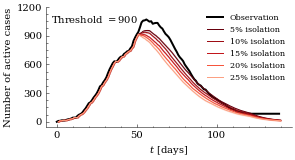

In [35]:
number_of_cases = [np.count_nonzero(nodes_at_time(i,'ori', sir_obj)) for i in range(maximum_days)]
width_pt = 397
fig_height, fig_aspect = plotutils.get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(2 * fig_height, fig_height))
import matplotlib.pylab as pl
# Greens, Wistia
colors = pl.cm.Reds(np.linspace(0,1,10))
ax.plot(range(maximum_days), number_of_cases, label = 'Observation', linewidth=2.0, color = 'k')
sns.lineplot(data=dfss[0], x="days", y="Number of cases", label = '5% isolation', color = colors[9]).set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=dfss[1], x="days", y="Number of cases", label = '10% isolation', color = colors[8]).set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=dfss[2], x="days", y="Number of cases", label = '15% isolation', color = colors[7]).set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=dfss[3], x="days", y="Number of cases", label = '20% isolation', color = colors[5]).set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
sns.lineplot(data=dfss[4], x="days", y="Number of cases", label = '25% isolation', color = colors[3]).set(xlabel= "$t$ [days]", ylabel= "Number of active cases")
ax.set_yticks(range(0,1500,300))
ax.set_xticks(range(0,150, 50))
ax.legend(loc = 'upper right', fontsize=8)
ax.text(0.2, 0.9,'Threshold $= 900$',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
# ax.legend(loc = 'upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('FIG/sir_multi_isolation_3.pdf', bbox_inches = 'tight')

## Intervention 2: Vaccination

In [12]:
reduction = 0.1
number_of_counterfactuals = 20
maximum_days = sir_obj.max_time + 20
print('Current Beta: ', sir_obj.beta)
print('Vaccinated Beta: ', reduction * sir_obj.beta)

Current Beta:  0.06535947712418301
Vaccinated Beta:  0.006535947712418302


In [ ]:
reduction = 0.1
vaccinated = np.random.choice(a=[False, True], size=(sir_obj.n_nodes,), p=[1 - 0.5, 0.5])
sir_obj.calculate_counterfactual(reduction * sir_obj.beta, sir_obj.G, vaccine = vaccinated)
# Ignore the warnings :)

In [15]:
def counterfactualr(_):
    sir_obj.calculate_counterfactual(_ * sir_obj.beta, sir_obj.G, vaccine = vaccinated)
    res = [sir_obj.cf_inf[i] for i in range(sir_obj.n_nodes) if sir_obj.cf_inf[i]!=np.inf]
    return len(res)
# return the number of infected people after intervention during the pandemic.

In [16]:
beta_reductions = [0.1, 0.2, 0.3, 0.4, 0.5]
percentage_vaccinated = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
number_of_counterfactuals = 20
dfs = []
all_cases = {}
for bet in beta_reductions:
    for per in percentage_vaccinated:
        cases = 0
        for k in range(5):
            vaccinated = np.random.choice(a=[False, True], size=(sir_obj.n_nodes,), p=[1 - per, per])
            with Pool(48) as pool:
                result = list(tqdm(pool.imap(counterfactualr, [bet for i in range(number_of_counterfactuals)]), total = number_of_counterfactuals))
            cases += sum(result)
        all_cases[(bet, per)] = cases / 250

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.43it/s]


In [17]:
obseved_cases = len(obs_infected)
obs_infected = [sir_obj.inf_occured_at[i] for i in range(sir_obj.n_nodes) if sir_obj.inf_occured_at[i]!=np.inf]
print(obseved_cases)
effectvity = pd.DataFrame(columns=['Beta', 'vacc', 'reduction'])
i = 0
for k, v in all_cases.items():
    effectvity.loc[i] = [100 - k[0] * 100, k[1] * 100, (obseved_cases - v) * 100 / obseved_cases]
    i += 1
effectvity = effectvity.astype({"Beta": int, "vacc": int})
# effectvity = effectvity.sort_values(['Beta'], ascending=[True])
# effectvity = effectvity.pivot("Beta", "vacc", "reduction")
effectvity.sort_values('vacc',axis=0,ascending=True, inplace = True)
effectvity.sort_values('Beta',axis=0,ascending=True, inplace = True)
effectvity_copy = copy.deepcopy(effectvity)
effectvity = effectvity.pivot("Beta", "vacc", "reduction")
arr = np.zeros((5, 8))
for i in range(5):
    for j in range(8):
        arr[4 - i, j] = effectvity.iloc[i, j]
effectvity.shape

4922


(5, 8)

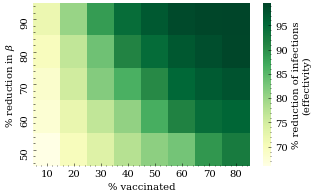

In [23]:
width_pt = 397
fig_height, fig_aspect = plotutils.get_fig_dim(width_pt, fraction=0.65)
fig, ax = plt.subplots(figsize=(fig_aspect * 3, 3))
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
sns.heatmap(arr, xticklabels = [10, 20, 30, 40, 50, 60, 70, 80], yticklabels = [90, 80, 70, 60, 50], cbar_kws={'label': '% reduction of infections\n(effectivity)'}, cmap = 'YlGn').set(xlabel = '% vaccinated', ylabel = r'% reduction in $\beta$')
fig.savefig('FIG/sir_obj_effectivity.pdf', bbox_inches = 'tight')

In [45]:
# points = effectvity_copy[['Beta', 'vacc']].to_numpy()
# i, j = 0, 1
# points.T[[i, j]] = points.T[[j, i]]
# values = effectvity_copy[['reduction']].to_numpy()
# print(points.shape)
# print(values.shape)

(40, 2)
(40, 1)


In [62]:
# np.save('Data/points.npy', points)
# np.save('Data/values.npy', values)
points = np.load('Data/points.npy')
values = np.load('Data/values.npy')

In [36]:
import matplotlib.colors as colors
from scipy.interpolate import griddata
import matplotlib

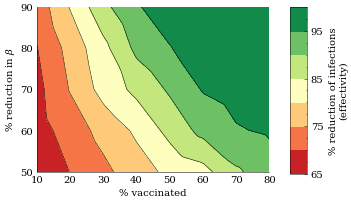

In [58]:
zmin, zmax_color, zmax_colorbar = 65, 100, 100
cmap='RdYlGn'
stepsize = 5
norm = colors.Normalize(vmin=zmin, vmax=zmax_color)
levels = np.arange(zmin, zmax_colorbar + stepsize, stepsize)
fig, axs = plt.subplots(1, 1, figsize=(1.6 * 3, 3))
x = np.array([10, 20, 30, 40, 50, 60, 70, 80])
y = np.array([50, 60, 70, 80, 90])
z = arr
xbounds = min(x), max(x)
ybounds = min(y), max(y)
axs.set_xlabel('% vaccinated')
xi = np.linspace(xbounds[0], xbounds[1], 100)
yi = np.linspace(ybounds[0], ybounds[1], 100)
zi = griddata(points, values, (xi[None,:], yi[:,None]), method='linear').reshape((100, 100))
axs.contour(xi, yi, zi, linewidths=0.5, colors='k', norm=norm, levels=levels)
contourplot = axs.contourf(xi, yi, zi, cmap=cmap, norm=norm, levels=levels)

# axis
axs.set_xlim(xbounds)
axs.set_ylim(ybounds)
# axs.set_title(title)

# axs.set_yticks(list(axs.get_yticks())[1:] + [ybounds[0]])
axs.set_yticks(y)
axs.set_xticks(x)
axs.set_ylabel(r'% reduction in $\beta$')
fig.tight_layout()
fig.subplots_adjust(right=0.8)

# [left, bottom, width, height]
# [0.84, 0.255, 0.025, 0.5]
# [0.87, 0.17, 0.05, 0.7]
cbar_ax = fig.add_axes([0.86, 0.16, 0.05, 0.77])
cbar = matplotlib.colorbar.ColorbarBase(
    cbar_ax, cmap=plt.cm.RdYlGn,
    norm=norm,
    boundaries=levels,
    ticks=levels[::2],
    orientation='vertical')
cbar.set_label('% reduction of infections\n(effectivity)', labelpad=5.0)
fig.savefig('FIG/effectivity.pdf', bbox_inches = 'tight')

In [ ]:
# def plot_epidemic(G, sir, t):

#     sus = np.vectorize(sir.idx_to_node.get)(np.where(sir.nodes_at_time('S', t))[0]).tolist()
#     rec = np.vectorize(sir.idx_to_node.get)(np.where(sir.nodes_at_time('R', t))[0]).tolist()
    
#     print('Plotting ...')
    
#     pos = nx.spring_layout(G, k=0.1)

#     plt.figure(figsize=(15, 15))
#     nx.draw_networkx_edges(G, pos, alpha=1.0) # potentially draw infector pathways bigger

#     nx.draw_networkx_nodes(G, pos, nodelist=sus,
#                         node_size=50,
#                         node_color='white',
#                         linewidths=0.7,
#                         edgecolors='black',
#                         label='healthy')
    
#     nx.draw_networkx_nodes(G, pos, nodelist=rec,
#                         node_size=50,
#                         node_color='grey',
#                         linewidths=0.7,
#                         edgecolors='black',
#                         label='removed')
#     plt.axis('off')
#     plt.legend(numpoints=1)
#     # plt.savefig('graph.pdf')


# plot_epidemic(sir_obj.G, sir_obj, 30)